In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc, accuracy_score


pd. set_option("display.max_columns", None)
pd. set_option("display.max_rows", None)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df_raw = pd.read_csv('credit_card_2015_2016.csv')

In [4]:
df_raw.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,loan_status
0,60 months,C4,C,10+ years,15,87.1,14.31,702.30,350349,36.91,35256,100,1,98000.0,29975,Fully Paid
1,60 months,C1,C,< 1 year,15,57.0,12.29,268.70,43525,18.80,2990,100,2,45000.0,12000,Fully Paid
2,36 months,B3,B,1 year,15,42.8,9.99,258.10,72655,19.34,6569,100,5,62500.0,8000,Fully Paid
3,36 months,A4,A,3 years,15,95.7,7.26,433.95,62695,11.31,9416,100,0,127000.0,14000,Fully Paid
4,36 months,B5,B,< 1 year,15,91.8,11.53,758.78,120674,23.07,7059,100,6,116000.0,23000,Fully Paid


In [5]:
df_raw.info() #emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    40000 non-null  object 
 1   sub_grade               40000 non-null  object 
 2   grade                   40000 non-null  object 
 3   emp_length              37459 non-null  object 
 4   issue_y                 40000 non-null  int64  
 5   revol_util_n            40000 non-null  float64
 6   int_rate_n              40000 non-null  float64
 7   installment_n           40000 non-null  float64
 8   tot_hi_cred_lim_n       40000 non-null  int64  
 9   dti_n                   40000 non-null  float64
 10  avg_cur_bal_n           40000 non-null  int64  
 11  all_util_n              40000 non-null  int64  
 12  acc_open_past_24mths_n  40000 non-null  int64  
 13  annual_inc_n            40000 non-null  float64
 14  loan_amnt_n             40000 non-null

In [6]:
# Separate training and OOT data
df_train = df_raw[df_raw['issue_y'] == 15].copy()
df_oot = df_raw[df_raw['issue_y'] == 16].copy()

print(df_train.shape, df_oot.shape)

(20000, 16) (20000, 16)


In [7]:
df_train.info() # emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    20000 non-null  object 
 1   sub_grade               20000 non-null  object 
 2   grade                   20000 non-null  object 
 3   emp_length              18747 non-null  object 
 4   issue_y                 20000 non-null  int64  
 5   revol_util_n            20000 non-null  float64
 6   int_rate_n              20000 non-null  float64
 7   installment_n           20000 non-null  float64
 8   tot_hi_cred_lim_n       20000 non-null  int64  
 9   dti_n                   20000 non-null  float64
 10  avg_cur_bal_n           20000 non-null  int64  
 11  all_util_n              20000 non-null  int64  
 12  acc_open_past_24mths_n  20000 non-null  int64  
 13  annual_inc_n            20000 non-null  float64
 14  loan_amnt_n             20000 non-null  int

Create the dichotomous output variable 'Outcome' by combining Charge off (which is actual loss) with Late (31-120 days) which is likely to be a loss

In [8]:
# Create Outcome variable (simply put, 1 means bad  or risky loan, 0 means good loan)
df_train['Outcome'] = df_train['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)'] else 0)
print(df_train['Outcome'].value_counts())
print(df_train['Outcome'].value_counts(normalize=True))

Outcome
0    16401
1     3599
Name: count, dtype: int64
Outcome
0    0.82005
1    0.17995
Name: proportion, dtype: float64


In [9]:
# Basic information of categorical data
print("Counts of categorical features:\n", df_train.describe(include=['object', 'category']))
print('************Loan Status Counts******************')
print(df_train.value_counts(['loan_status']))
print(df_train['loan_status'].value_counts(normalize=True))
print('************Term Counts******************')
print(df_train.value_counts(['term']))
print(df_train['term'].value_counts(normalize=True))
print('*********Grade Counts*************')
print(df_train.value_counts(['grade']))
print(df_train['grade'].value_counts(normalize=True))
print('*********Sub Grade Counts*************')
print(df_train.value_counts(['sub_grade']))
print(df_train['sub_grade'].value_counts(normalize=True))

Counts of categorical features:
              term sub_grade  grade emp_length loan_status
count       20000     20000  20000      18747       20000
unique          2        34      7         11           3
top     36 months        A5      B  10+ years  Fully Paid
freq        15696      1606   6805       6099       16401
************Loan Status Counts******************
loan_status       
Fully Paid            16401
Charged Off            3413
Late (31-120 days)      186
Name: count, dtype: int64
loan_status
Fully Paid            0.82005
Charged Off           0.17065
Late (31-120 days)    0.00930
Name: proportion, dtype: float64
************Term Counts******************
term     
36 months    15696
60 months     4304
Name: count, dtype: int64
term
36 months    0.7848
60 months    0.2152
Name: proportion, dtype: float64
*********Grade Counts*************
grade
B        6805
A        5902
C        4760
D        1645
E         734
F         137
G          17
Name: count, dtype: int64
grade

In [10]:
# Map emp_length to ordinal numbers as per the feature definition ( Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years)
emp_length_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                  '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}

df_train['emp_length'] = df_train['emp_length'].map(emp_length_map)

# Check missing values
print(df_train['emp_length'].isnull().sum())

1253


In [11]:
print("\nBasic Statistics of Numerical features:\n", df_train.describe().round(2))


Basic Statistics of Numerical features:
        emp_length  issue_y  revol_util_n  int_rate_n  installment_n  \
count    18747.00  20000.0      20000.00    20000.00       20000.00   
mean         5.73     15.0         56.52       10.79         451.95   
std          3.75      0.0         22.25        3.75         246.46   
min          0.00     15.0         -1.00        5.32          30.12   
25%          2.00     15.0         39.90        7.89         267.21   
50%          6.00     15.0         56.50        9.99         392.81   
75%         10.00     15.0         73.53       12.99         602.30   
max         10.00     15.0        124.70       27.88        1306.90   

       tot_hi_cred_lim_n     dti_n  avg_cur_bal_n  all_util_n  \
count           20000.00  20000.00       20000.00    20000.00   
mean           173900.06     18.93       12949.71       98.50   
std            177436.45      8.47       15657.95        8.37   
min              2700.00      0.00           7.00        4

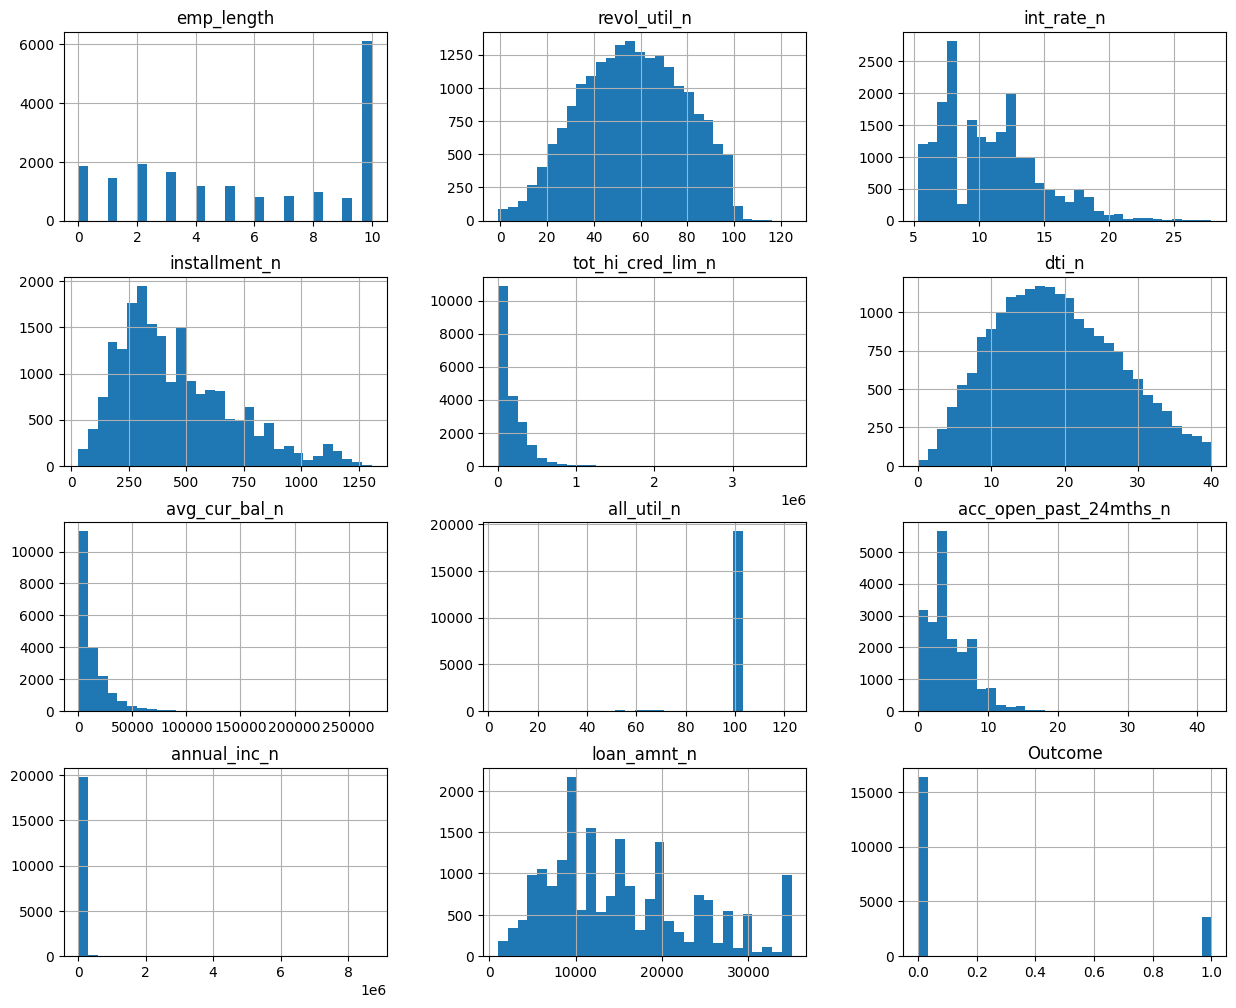

In [12]:
# Distribution plots for numerical features (excluding issue year)
num_cols = [col for col in df_train.select_dtypes(include='number').columns if col != 'issue_y']
df_train[num_cols].hist(figsize=(15, 12), bins=30)
plt.show()

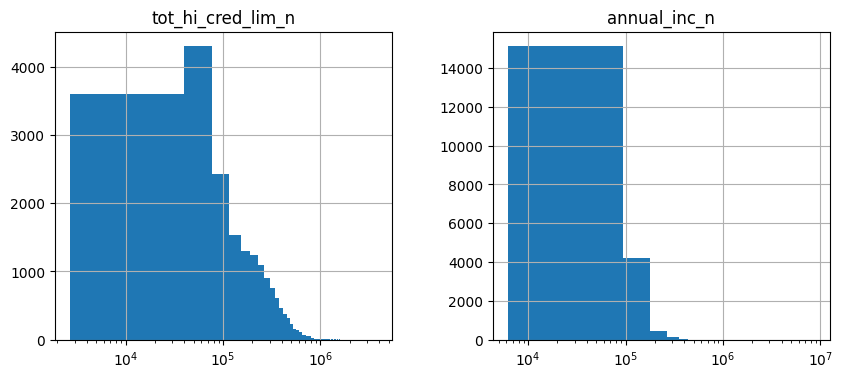

In [13]:
# Analyze these 2 by increasing the # of bins as the distribution with 30 bins is not clear
axes = df_train[['tot_hi_cred_lim_n', 'annual_inc_n']].hist(bins=100, figsize=(10, 4))
for ax in axes.flatten():
    ax.set_xscale('log')
# plt.tight_layout()
plt.show()

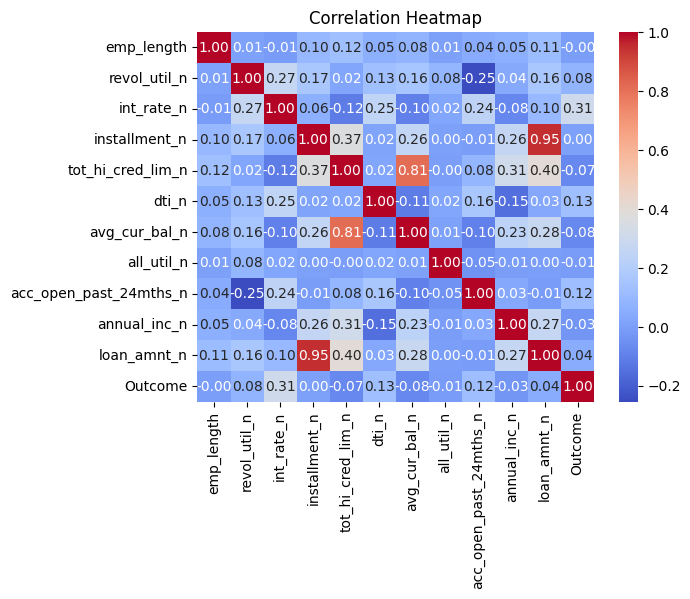

In [14]:
# Correlation map
# plt.figure(figsize=(12, 10))
sns.heatmap(df_train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

XGBoost handles multicollinearity automatically during training, so dropping highly correlated features (with 0.95 and 0.81 correlation) is not strictly necessary but we will handle them in the experiment 2 with feature engineering

In [ ]:
# drop installment_n and update the list of numerical columns
# df_train.drop(['installment_n'], axis=1, inplace=True)
# num_cols.remove('installment_n')


Plot the numerical features against the Outcome variable

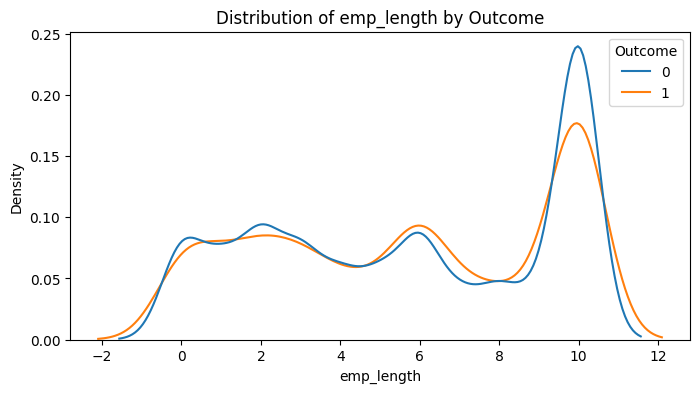

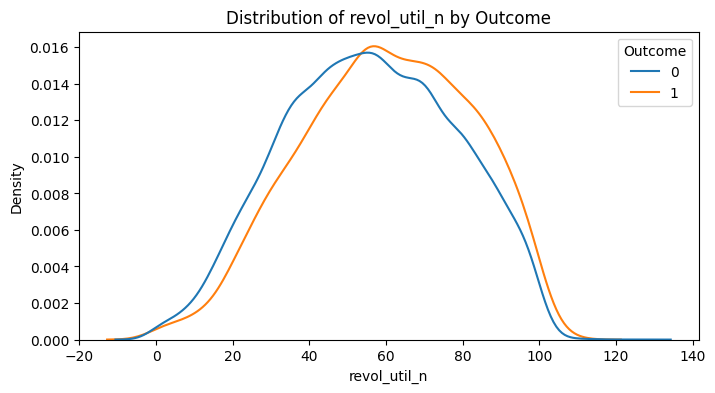

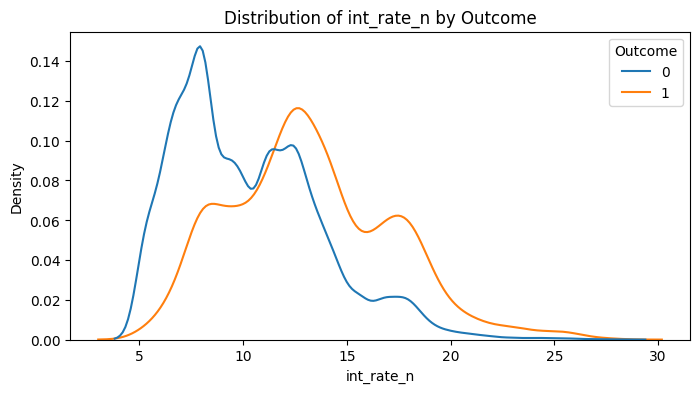

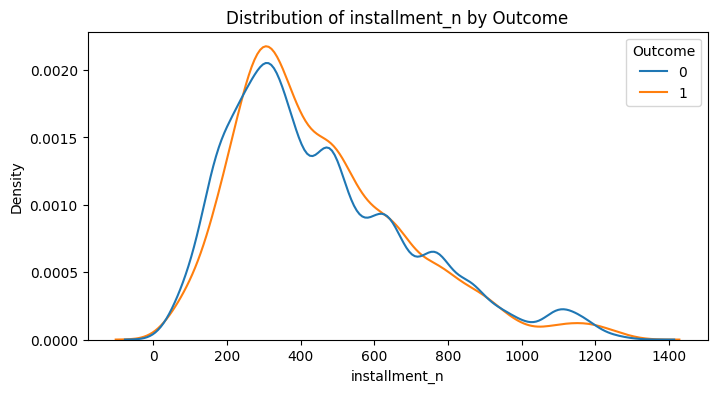

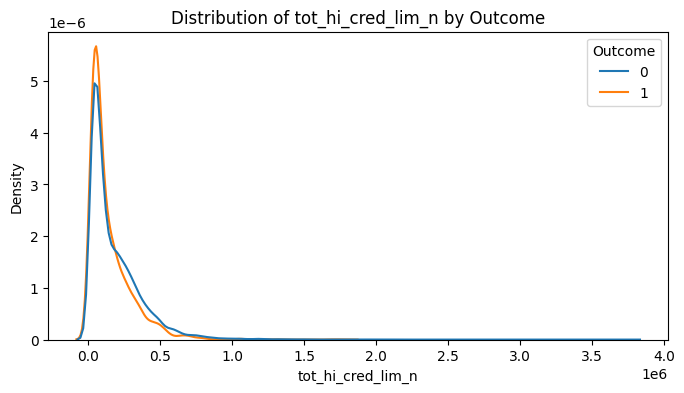

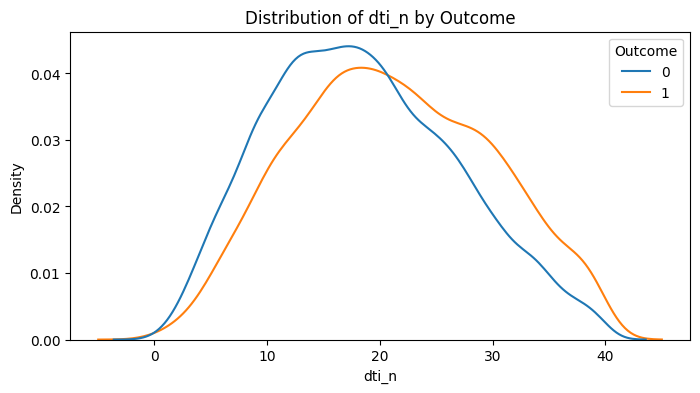

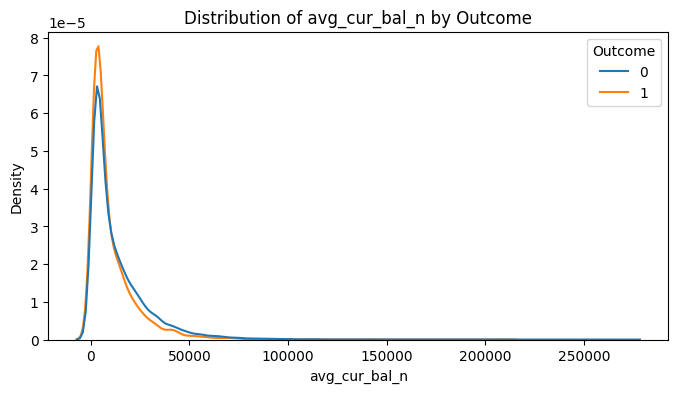

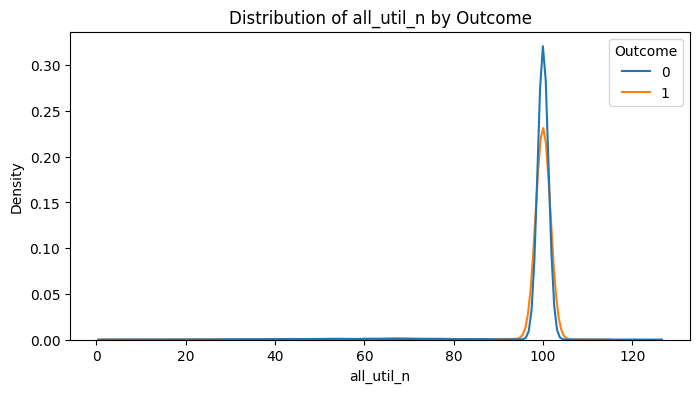

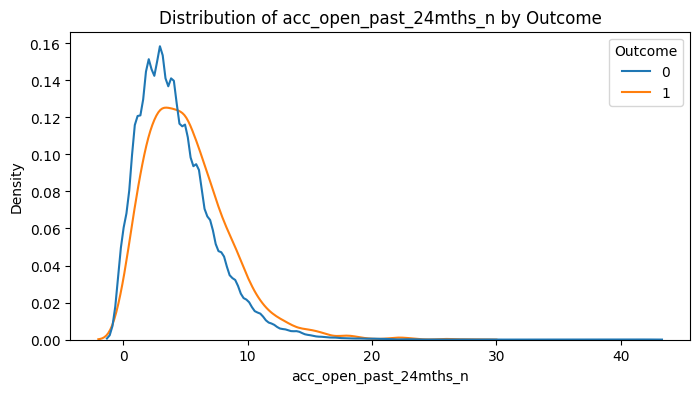

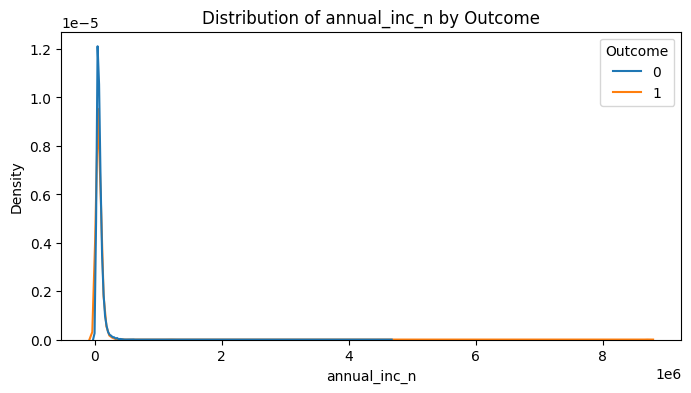

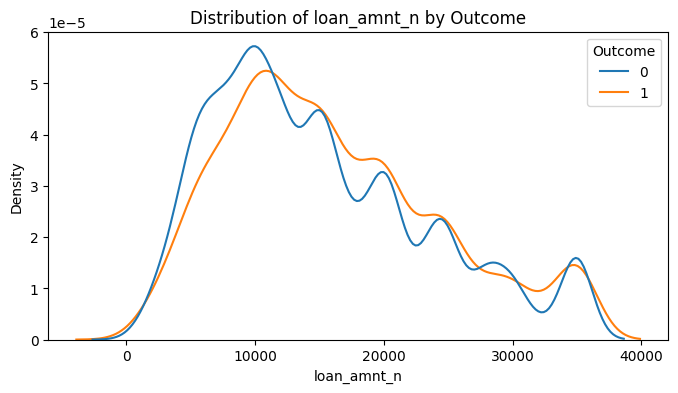

In [ ]:
num_cols.remove('Outcome')

for feature in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df_train, x=feature, hue='Outcome', common_norm=False) #Common_norm false means each group’s density curve is normalized independently
    plt.title(f'Distribution of {feature} by Outcome')
    plt.show()

Boxplot and outlier check: xgboost is generally robust to outliers, but it may impact the generalizability of the model

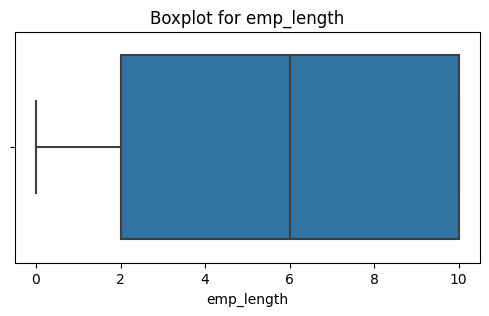

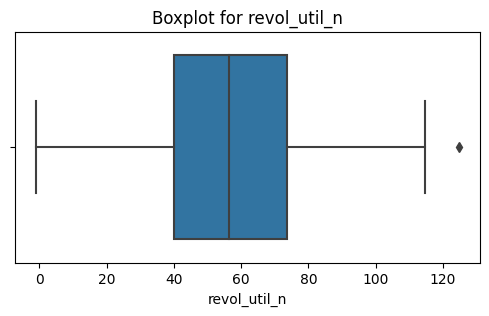

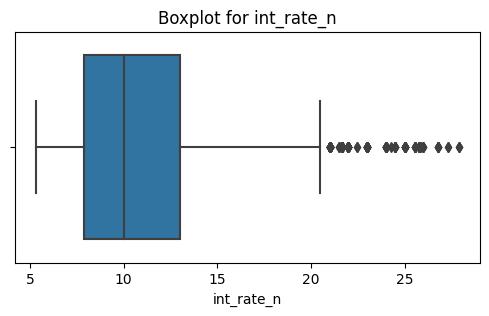

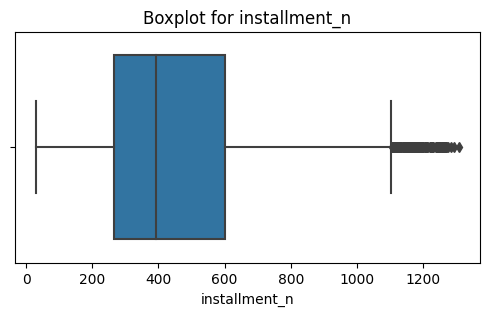

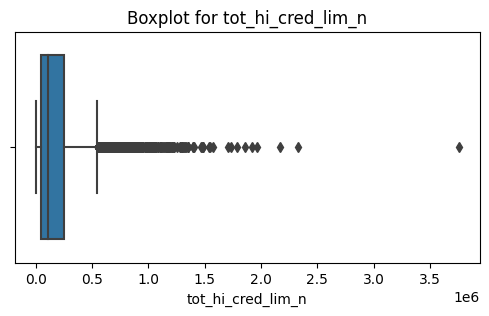

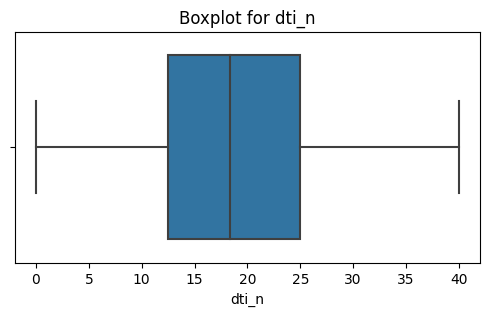

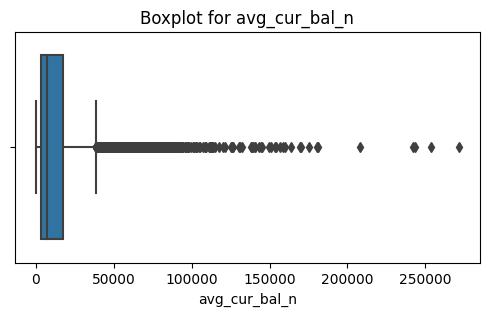

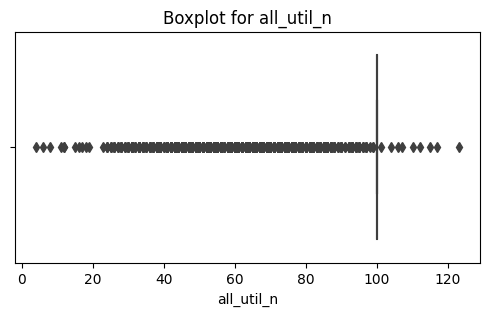

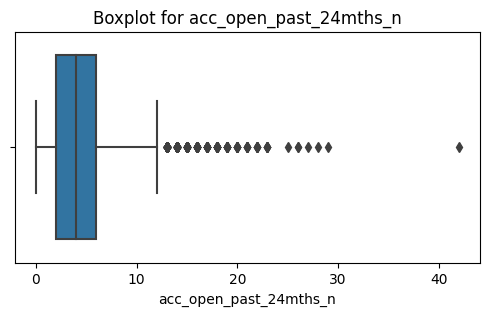

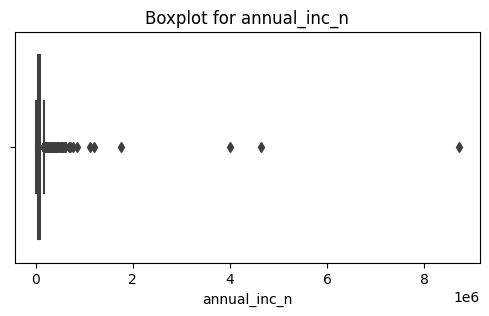

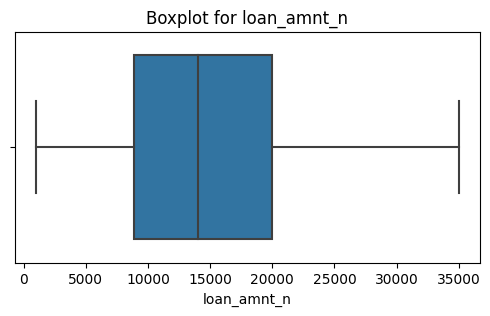

emp_length                   0
revol_util_n                 1
int_rate_n                 251
installment_n              398
tot_hi_cred_lim_n          763
dti_n                        0
avg_cur_bal_n             1262
all_util_n                 773
acc_open_past_24mths_n     397
annual_inc_n               947
loan_amnt_n                  0
dtype: int64


In [23]:
# Check for outliers
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Outlier detection using IQR
Q1 = df_train[num_cols].quantile(0.25)
Q3 = df_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_train[num_cols] < (Q1 - 1.5 * IQR)) | (df_train[num_cols] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

Run t-test and Manwhitneyu to check if there is statistically significant difference between the means of a numerical variables for good and bad loans

Unlike the t-test, which compares means and assumes that the data are normally distributed and have equal variances, Mann-WhitneyU test does not require the data to be normally distributed and is suitable for data when the assumptions of the t-test are not met

In [24]:
results = []

for col in num_cols:
    group0 = df_train[df_train['Outcome'] == 0][col].dropna()
    group1 = df_train[df_train['Outcome'] == 1][col].dropna()
    
    # t-test
    t_stat, t_p = ttest_ind(group0, group1, equal_var=False)
    # Mann-Whitney U test
    u_stat, u_p = mannwhitneyu(group0, group1, alternative='two-sided')
    
    # Significance check (alpha = 0.05)
    t_significant = 'Significant' if t_p < 0.05 else 'Not Significant'
    u_significant = 'Significant' if u_p < 0.05 else 'Not Significant'
    
    results.append({
        'feature': col,
        't-test p-value': t_p,
        't-test significance': t_significant,
        'Mann-Whitney p-value': u_p,
        'Mann-Whitney significance': u_significant
    })

summary_df = pd.DataFrame(results)
print(summary_df)


                   feature  t-test p-value t-test significance  \
0               emp_length    5.940129e-01     Not Significant   
1             revol_util_n    1.036634e-27         Significant   
2               int_rate_n    0.000000e+00         Significant   
3            installment_n    7.287874e-01     Not Significant   
4        tot_hi_cred_lim_n    8.128528e-33         Significant   
5                    dti_n    9.970022e-66         Significant   
6            avg_cur_bal_n    1.184267e-35         Significant   
7               all_util_n    1.402460e-01     Not Significant   
8   acc_open_past_24mths_n    1.963690e-56         Significant   
9             annual_inc_n    5.576249e-03         Significant   
10             loan_amnt_n    2.141723e-10         Significant   

    Mann-Whitney p-value Mann-Whitney significance  
0           5.684909e-01           Not Significant  
1           3.581338e-27               Significant  
2           0.000000e+00               Significa

In [ ]:
# from scipy.stats import f_oneway
# import pandas as pd

# anova_results = []

# for col in num_cols:
#     # Extract the values for each Outcome group
#     groups = [df_train[df_train['Outcome'] == outcome][col].dropna() for outcome in df_train['Outcome'].unique()]
    
#     # Perform ANOVA if there are at least 2 groups with data
#     if len(groups) >= 2 and all(len(g) > 0 for g in groups):
#         f_stat, p_val = f_oneway(*groups)
#         anova_results.append({'Variable': col, 'F-statistic': f_stat, 'p-value': p_val})
#     else:
#         anova_results.append({'Variable': col, 'F-statistic': None, 'p-value': None})
    
# # Display results as a DataFrame
# anova_df = pd.DataFrame(anova_results)
# anova_df['Significant'] = np.where(anova_df['p-value'] < 0.05, 'Yes', 'No')
# print(anova_df)


In [25]:
# impute employee length using KNN

# imputer = KNNImputer(n_neighbors=5)
# df_train[['emp_length_n_new']] = imputer.fit_transform(df_train[['emp_length_n']])

# diff_mask = df_train['emp_length_n'] != df_train['emp_length_n_new']
# differences = df_train.loc[diff_mask, ['emp_length_n', 'emp_length_n_new']]
# print(differences)

# KNN imputer imputed missing values with mean 5.72 which is not appropriate for an ordinal variable
# On diff note, 10 is much more frequent than other values, imputing with 10 will further increase its dominance 

df_train['emp_length'].fillna(df_train['emp_length'].median(), inplace=True)

In [26]:
print("\nMissing Values:\n", df_train['emp_length'].isnull().sum())


Missing Values:
 0


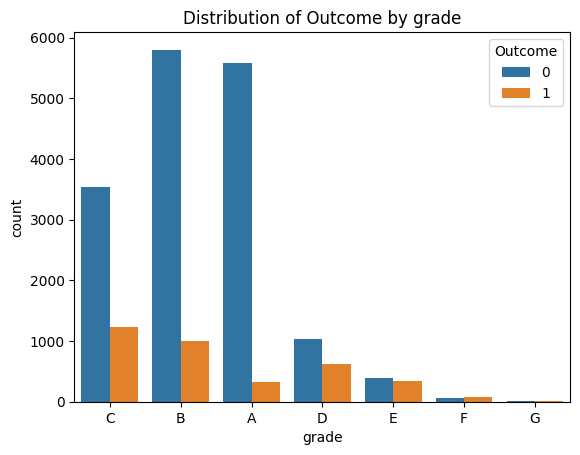

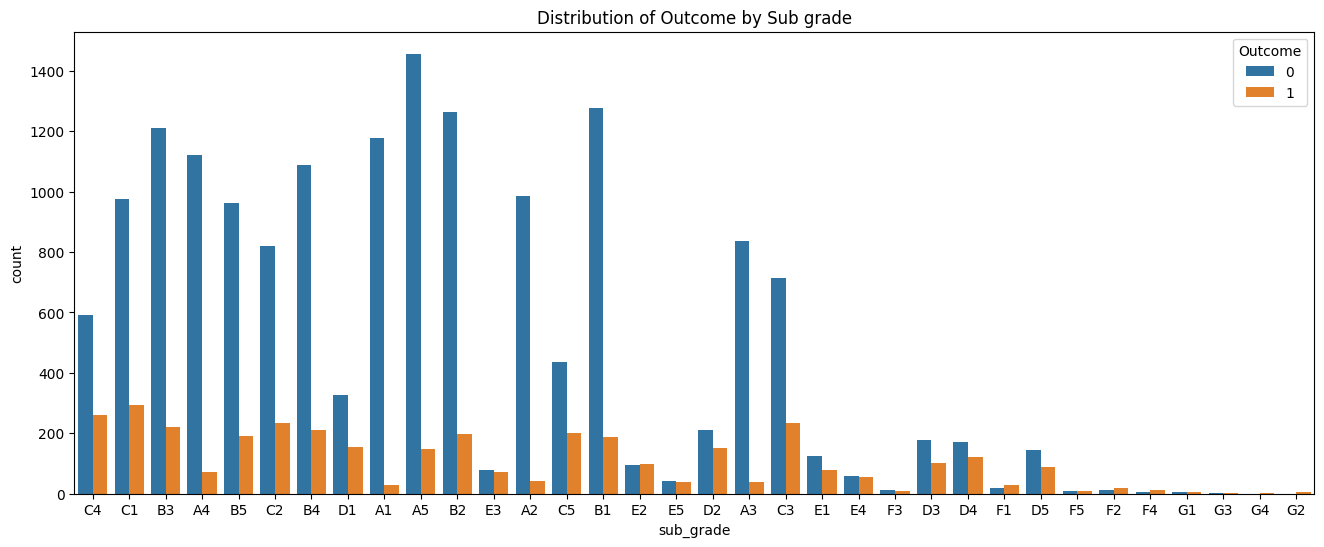

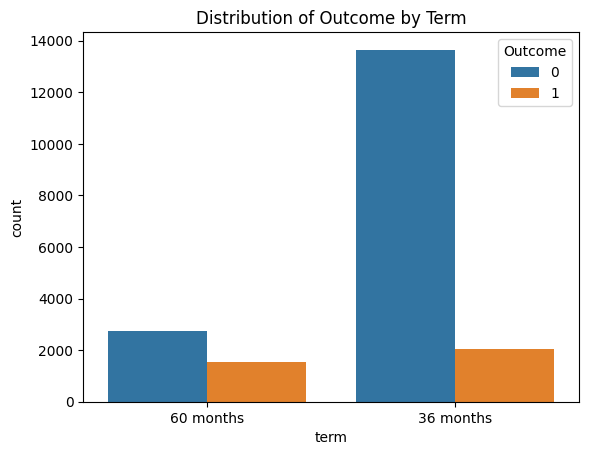

In [45]:
#Plot categorical variables with Outcome variable
sns.countplot(data=df_train, x='grade', hue='Outcome')
plt.title('Distribution of Outcome by grade')
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(data=df_train, x='sub_grade', hue='Outcome')
plt.title('Distribution of Outcome by Sub grade')
plt.show()

sns.countplot(data=df_train, x='term', hue='Outcome')
plt.title('Distribution of Outcome by Term')
plt.show()

Run the chi-square test to determine whether there is a significant relationship between the categorical variables and Outcome

In [46]:
cat_cols = ['term', 'grade', 'sub_grade']
target = 'Outcome'

def chi_square_test(data, predictor, target):
    contingency_table = pd.crosstab(data[predictor], data[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Store results
results = []

for col in cat_cols:
    chi2, p = chi_square_test(df_train, col, target)
    significance = 'Significant' if p < 0.05 else 'Not Significant'
    results.append({'feature': col, 'chi2_stat': chi2, 'p_value': p, 'significance': significance})

# Display as DataFrame
results_df = pd.DataFrame(results)
print(results_df)


     feature    chi2_stat        p_value significance
0       term  1208.077035  1.071369e-264  Significant
1      grade  1838.200860   0.000000e+00  Significant
2  sub_grade  1961.877626   0.000000e+00  Significant


Since sub_grade is at more granular level of grade, there is a possibility they are closely associated. We can check with Cramer's V which measures the strength of association between two categorical variables 

In [165]:
contingency = pd.crosstab(df_train['grade'], df_train['sub_grade'])
chi2, p, dof, expected = chi2_contingency(contingency)
# Calculate Cramer’s V
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))
print(cramers_v)

1.0


In [49]:
df_train_coded=df_train.copy()

In [50]:
# Encode categorical variables
le = LabelEncoder()
df_train_coded['sub_grade'] = le.fit_transform(df_train_coded['sub_grade'])
df_train_coded['grade'] = le.fit_transform(df_train_coded['grade'])
df_train_coded['term'] = le.fit_transform(df_train_coded['term'])

In [51]:
df_train_coded.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,loan_status,Outcome
0,1,13,2,10.0,15,87.1,14.31,702.30,350349,36.91,35256,100,1,98000.0,29975,Fully Paid,0
1,1,10,2,0.0,15,57.0,12.29,268.70,43525,18.80,2990,100,2,45000.0,12000,Fully Paid,0
2,0,7,1,1.0,15,42.8,9.99,258.10,72655,19.34,6569,100,5,62500.0,8000,Fully Paid,0
3,0,3,0,3.0,15,95.7,7.26,433.95,62695,11.31,9416,100,0,127000.0,14000,Fully Paid,0
4,0,9,1,0.0,15,91.8,11.53,758.78,120674,23.07,7059,100,6,116000.0,23000,Fully Paid,0


Build the xgboost models using 5-fold cross-validation, repeated 3 times using different random seeds

In [52]:
X = df_train_coded.drop(['loan_status', 'Outcome', 'issue_y'], axis=1)
y = df_train_coded['Outcome']

def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# gini_scorer = make_scorer(gini_score, needs_proba=True)

results = []

# Define your random seeds for the 3 repetitions
seeds = [92, 123, 999]

for seed in seeds:
    # StratifiedKFold for class balance in each fold
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)
    for fold, (train_i, val_i) in enumerate(kf.split(X, y), 1):
        X_train, X_val = X.iloc[train_i], X.iloc[val_i]
        y_train, y_val = y.iloc[train_i], y.iloc[val_i]
        
        # Train XGBoost model
        model = XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=seed)
        model.fit(X_train, y_train)
        
        # Predict probabilities and classes
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)
        gini = gini_score(y_val, y_pred_proba)
        
        # Store results
        results.append({
            'Seed': seed,
            'Fold': fold,
            'Accuracy': round(accuracy, 3),
            'AUC-ROC': round(auc, 3),
            'Gini': round(gini, 3)
        })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

# Print all results
print("Cross-Validation Results (15 Models):")
print(results_df)

# Print average metrics across all runs
print("\nAverage Metrics Across All Runs:")
print(results_df[['Accuracy', 'AUC-ROC', 'Gini']].mean().round(3))
print("\nStandard deviation of Gini:")
print(results_df[['Gini']].std().round(3))


Cross-Validation Results (15 Models):
    Seed  Fold  Accuracy  AUC-ROC   Gini
0     92     1     0.815    0.709  0.418
1     92     2     0.813    0.704  0.408
2     92     3     0.811    0.703  0.405
3     92     4     0.814    0.701  0.402
4     92     5     0.809    0.696  0.392
5    123     1     0.808    0.705  0.409
6    123     2     0.819    0.707  0.415
7    123     3     0.817    0.712  0.424
8    123     4     0.808    0.705  0.409
9    123     5     0.818    0.697  0.395
10   999     1     0.811    0.702  0.405
11   999     2     0.811    0.703  0.406
12   999     3     0.816    0.715  0.430
13   999     4     0.816    0.695  0.391
14   999     5     0.815    0.715  0.430

Average Metrics Across All Runs:
Accuracy    0.813
AUC-ROC     0.705
Gini        0.409
dtype: float64

Standard deviation of Gini:
Gini    0.012
dtype: float64


Hyper-parameter tuning

In [53]:
# Define hyperparameter grid 
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

In [ ]:
gini_scorer = make_scorer(gini_score, needs_proba=True) #wrap the gini_score in order to use it as a scoring parameter

# XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=99)

# RepeatedStratifiedKFold CV with 5 splits and repeated 3 times
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,   # Number of random combinations to try
    scoring=gini_scorer,
    n_jobs=-1,   # Use all cores
    cv=cv,
    verbose=2,
    random_state=11,
    return_train_score=True
)

# Fit the search
random_search.fit(X, y)

# Best parameters
# print("\nBest Parameters:", random_search.best_params_)

# Best Gini score from CV (mean of CV folds)
# print("Best CV Gini Score:", random_search.best_score_)

# Find std deviation of Gini for the best parameter set
# best_index = random_search.best_index_
# best_gini_std = random_search.cv_results_['std_test_score'][best_index]

# print(f"Std Dev of Gini for Best CV Score: {best_gini_std:.4f}")

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best Parameters found: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best CV Gini Score: 0.4893564221660834
Std Dev of Gini for Best CV Score: 0.0218


Select best model by balancing performance (mean Gini) with stability (std dev of Gini) 

In [56]:
# Extract mean and std Gini scores for all models
mean_ginis = random_search.cv_results_['mean_test_score']
std_ginis = random_search.cv_results_['std_test_score']

# Find the best mean Gini score
best_mean_gini = np.max(mean_ginis)

# Define a threshold (5% of the best mean Gini)
threshold = best_mean_gini * 0.95

# Find indices of models within the threshold
candidate_indices = np.where(mean_ginis >= threshold)[0]

# Among candidates, pick the index with the lowest std deviation
best_index_by_stability = candidate_indices[np.argmin(std_ginis[candidate_indices])]

# Show the selected model's parameters, mean, and std Gini
print("Best Parameters (mean Gini & stability):", random_search.cv_results_['params'][best_index_by_stability])
print("Mean CV Gini Score:", mean_ginis[best_index_by_stability])
print("Std Dev of Gini:", std_ginis[best_index_by_stability])

Best Parameters (mean Gini & stability): {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Mean CV Gini Score: 0.48460467911311356
Std Dev of Gini: 0.02009233814621111


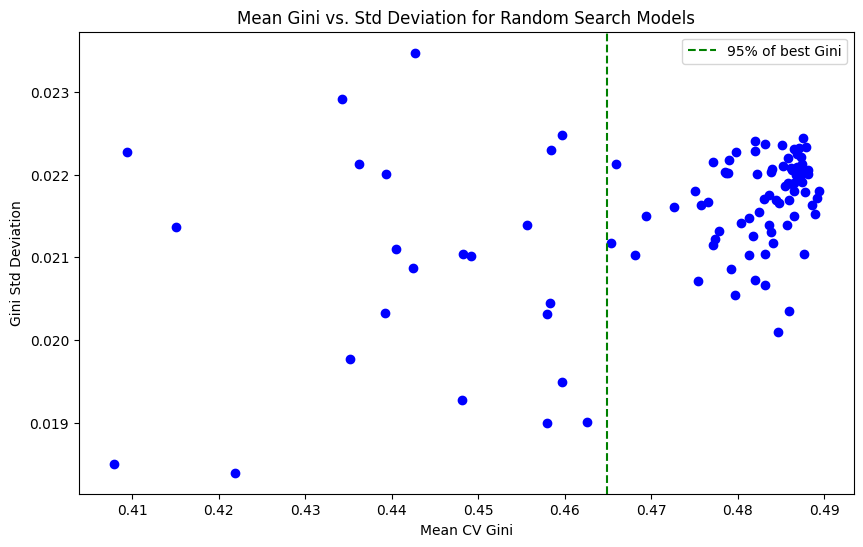

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(mean_ginis, std_ginis, c='blue')
plt.axvline(threshold, color='green', linestyle='--', label='95% of best Gini')
plt.xlabel('Mean CV Gini')
plt.ylabel('Gini Std Deviation')
plt.title('Mean Gini vs. Std Deviation for Random Search Models')
plt.legend()
plt.show()


Test the best selected model on OOT data (Ideal way is to create a pipeline of data cleaning/prep steps and pass the training and OOT data to it, but in the interest of time I'm perforing it in an adhoc way)

In [ ]:
# Encode categorical variables
le = LabelEncoder()
df_train_coded['sub_grade'] = le.fit_transform(df_train_coded['sub_grade'])
df_train_coded['grade'] = le.fit_transform(df_train_coded['grade'])
df_train_coded['term'] = le.fit_transform(df_train_coded['term'])

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 20000 to 39999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    20000 non-null  object 
 1   sub_grade               20000 non-null  object 
 2   grade                   20000 non-null  object 
 3   emp_length              20000 non-null  float64
 4   issue_y                 20000 non-null  int64  
 5   revol_util_n            20000 non-null  float64
 6   int_rate_n              20000 non-null  float64
 7   installment_n           20000 non-null  float64
 8   tot_hi_cred_lim_n       20000 non-null  int64  
 9   dti_n                   20000 non-null  float64
 10  avg_cur_bal_n           20000 non-null  int64  
 11  all_util_n              20000 non-null  int64  
 12  acc_open_past_24mths_n  20000 non-null  int64  
 13  annual_inc_n            20000 non-null  float64
 14  loan_amnt_n             20000 non-null 

In [76]:
y_oot.head()

20000    0
20001    0
20002    0
20003    0
20004    0
Name: Outcome, dtype: int64

In [ ]:
#Create Outcome variable
df_oot['Outcome'] = df_oot['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)'] else 0)

#Clean employee length
df_oot['emp_length'] = df_oot['emp_length'].map(emp_length_map)
df_oot['emp_length'].fillna(df_oot['emp_length'].median(), inplace=True)

num_cols = [col for col in df_train.select_dtypes(include='number').columns if col not in ['issue_y', 'Outcome']]

df_oot_coded=df_oot.copy()

# Encode categorical variables
le = LabelEncoder()
df_oot_coded['sub_grade'] = le.fit_transform(df_oot_coded['sub_grade'])
df_oot_coded['grade'] = le.fit_transform(df_oot_coded['grade'])
df_oot_coded['term'] = le.fit_transform(df_oot_coded['term'])


# Split out OOT features and target
X_oot = df_oot_coded.drop(['loan_status', 'Outcome', 'issue_y'], axis=1)
y_oot = df_oot_coded['Outcome']

In [78]:
# Get the best parameters from your RandomizedSearchCV selection strategy
best_params = random_search.cv_results_['params'][best_index_by_stability]

# Initialize a fresh model with best parameters
final_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=99, **best_params)

# Fit on the full training data (all CV folds combined)
final_model.fit(X, y)

# Predict on OOT data
oot_pred_proba = final_model.predict_proba(X_oot)[:, 1]
oot_pred = (oot_pred_proba >= 0.5).astype(int)

# Define your Gini scorer again
def gini_score(y_true, y_pred_proba):
    return 2 * roc_auc_score(y_true, y_pred_proba) - 1

# Calculate metrics
auc_oot = roc_auc_score(y_oot, oot_pred_proba)
gini_oot = gini_score(y_oot, oot_pred_proba)
acc_oot = accuracy_score(y_oot, oot_pred)

# Print results
print("OOT Data Performance:")
print(f"AUC-ROC: {auc_oot:.4f}")
print(f"Gini: {gini_oot:.4f}")
print(f"Accuracy: {acc_oot:.4f}")

OOT Data Performance:
AUC-ROC: 0.7028
Gini: 0.4057
Accuracy: 0.7488
